In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
from zipfile import ZipFile
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import os
import json

import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import models

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
'''!cp -r "/content/gdrive/My Drive/hw3_data_raw" "/content/hw3_data_raw"'''

In [3]:
defect_df = pd.read_csv('/content/hw3_data_raw/train.csv')

print(defect_df.shape)
defect_df.head()

(4985, 3)


,ImageId,ClassId,EncodedPixels
0,1,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,5,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,6,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,7,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,8,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
defect_df_gp = defect_df.groupby(by='ImageId', axis=0).agg('sum').drop("ClassId", axis=1)
defect_df_gp.reset_index(inplace=True)
defect_df_gp["allMissing"] = 0

train_name = sorted([int(name.split(".")[0]) for name in os.listdir('/content/hw3_data_raw/train_images')])
defect_name = sorted(list(defect_df_gp["ImageId"]))
nondefect_name = sorted(list(set(train_name)-set(defect_name)))

nondefect_df = pd.DataFrame(data={"ImageId": nondefect_name , "allMissing":1})

train_df_gp = pd.concat([defect_df_gp, nondefect_df])
train_df_gp = train_df_gp.sort_values("ImageId")
train_df_gp.reset_index(inplace=True)
train_df_gp = train_df_gp.drop("index", axis=1)
train_df_gp["ImageId"] = train_df_gp["ImageId"].astype("str")
train_df_gp["ImageId"] = train_df_gp["ImageId"].apply(lambda x: "{}.JPG".format(x))
train_df_gp

,ImageId,allMissing
0,1.JPG,0
1,2.JPG,1
2,3.JPG,1
3,5.JPG,0
4,6.JPG,0
...,...,...
8793,12561.JPG,0
8794,12563.JPG,1
8795,12564.JPG,1
8796,12567.JPG,0


In [5]:
defect_df_gp

,ImageId,allMissing
0,1,0
1,5,0
2,6,0
3,7,0
4,8,0
...,...,...
4677,12558,0
4678,12559,0
4679,12561,0
4680,12567,0


In [6]:
test_name = sorted([int(name.split(".")[0]) for name in os.listdir('/content/hw3_data_raw/test_images')])

test_df_gp = pd.DataFrame(data={"ImageId": test_name})
test_df_gp["ImageId"] = test_df_gp["ImageId"].astype("str")
test_df_gp["ImageId"] = test_df_gp["ImageId"].apply(lambda x: "{}.JPG".format(x))
test_df_gp

,ImageId
0,4.JPG
1,10.JPG
2,11.JPG
3,15.JPG
4,17.JPG
...,...
3765,12555.JPG
3766,12560.JPG
3767,12562.JPG
3768,12565.JPG


In [11]:
"""remove_model = load_model('/content/hw3_data_raw/model_predict_no_defect.h5')
remove_model.summary()"""

"remove_model = load_model('/content/hw3_data_raw/model_predict_no_defect.h5')\nremove_model.summary()"

In [0]:
def build_model():
    densenet = DenseNet121(
        include_top=False,
        input_shape=(256,256,3),
        weights='/content/hw3_data_raw/DenseNet-BC-121-32-no-top.h5'
    )
    
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Nadam(),
        metrics=['accuracy']
    )
    
    return model

In [8]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [14]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.15,

        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0.
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_df_gp, 
        directory='/content/hw3_data_raw/train_images',
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode="raw",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')

Found 7479 validated image filenames.
Found 1319 validated image filenames.


In [18]:
total_steps = train_df_gp.shape[0] / BATCH_SIZE

checkpoint = ModelCheckpoint(
    '/content/genre_train_model.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=40,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/40
234/233 [==============================] - 569s 2s/step - loss: 0.3623 - accuracy: 0.8358 - val_loss: 1.0964 - val_accuracy: 0.7528

Epoch 00001: val_accuracy improved from -inf to 0.75284, saving model to /content/genre_train_model.h5
Epoch 2/40
234/233 [==============================] - 494s 2s/step - loss: 0.3351 - accuracy: 0.8513 - val_loss: 0.0542 - val_accuracy: 0.7915

Epoch 00002: val_accuracy improved from 0.75284 to 0.79151, saving model to /content/genre_train_model.h5
Epoch 3/40
234/233 [==============================] - 493s 2s/step - loss: 0.3299 - accuracy: 0.8543 - val_loss: 1.6773 - val_accuracy: 0.6187

Epoch 00003: val_accuracy did not improve from 0.79151
Epoch 4/40
234/233 [==============================] - 493s 2s/step - loss: 0.3043 - accuracy: 0.8671 - val_loss: 0.8855 - val_accuracy: 0.6247

Epoch 00004: val_accuracy did not improve from 0.79151
Epoch 5/40
234/233 [==============================] - 492s 2s/step - loss: 0.2936 - accuracy: 0.8708 - va

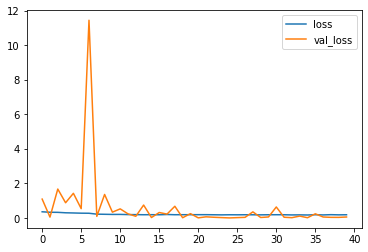

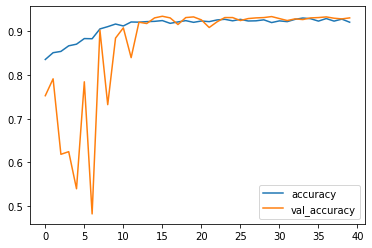

In [21]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [9]:
remove_model = model 
BATCH_SIZE = 50

def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_df_gp,
        directory='/content/hw3_data_raw/test_images',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

test_gen = create_test_gen()

remove_model.load_weights('/content/genre_train_model.h5')

test_nondefect_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

test_df_gp['allMissing'] = test_nondefect_pred
test_df_gp.head()
print(test_df_gp.shape)

Found 3770 validated image filenames.
76/76 [==============================] - 68s 891ms/step
(3770, 2)


In [10]:
print(test_df_gp['allMissing'].mean())
print(test_df_gp['allMissing'].min())
print(test_df_gp['allMissing'].max())

0.5857325792312622
6.150827847051232e-09
1.0


In [11]:
test_defect_df = test_df_gp[test_df_gp['allMissing'] < 0.5] #>0.5 means no defect

test_defect_df.reset_index(drop=True, inplace=True)

print(test_defect_df.shape)
test_defect_df.head()

(1563, 2)


,ImageId,allMissing
0,23.JPG,2.177453e-01
1,31.JPG,2.592341e-07
2,52.JPG,2.273133e-02
3,55.JPG,2.961169e-01
4,70.JPG,1.112970e-01


In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles


""""""


def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T


def build_masks(rles, input_shape):
    depth = 4
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if (rle != 0):
            masks[:, :, i] = rle2mask(rle, input_shape)

    return masks

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, base_path, IDs, target_df=None, mode='fit',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2020, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.mode = mode
        self.IDs = IDs
        self.base_path = base_path
        self.target_df = target_df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

        # Find list of IDs
        IDs_batch = [self.IDs[k] for k in indexes]
        
        X = self.__generate_X(IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(IDs_batch):
            im_name = str(ID)+".JPG"
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(IDs_batch):
            im_name = ID
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            im_id = image_df['ClassId'].values
            rles = image_df['EncodedPixels'].values

            defect_list = [0,0,0,0]
            for num, encode in zip(im_id, rles):
                if type(encode) is str:
                    defect_list[num-1] = encode

            masks = build_masks(defect_list, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img

In [14]:
defect_df.dtypes

ImageId           int64
ClassId           int64
EncodedPixels    object
dtype: object

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


genre_model = load_model(
                        "/content/hw3_data_raw/model_for_genre.h5",
                        custom_objects={'dice_coef': dice_coef})


genre_model.trainable = True
set_weight = False
for i, layer in enumerate(genre_model.layers):
    if(1):#3 6 9 12 15 17 19 23 "27" 31 35
        set_weight = True

    if set_weight:
        layer.trainable = True
    else:
        layer.trainable = False

genre_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [16]:
genre_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
BATCH_SIZE = 25

train_id, val_id = train_test_split(
    defect_df_gp["ImageId"].tolist(),  # name for imageid
    random_state=2020, 
    test_size=0.1
)

train_generator = DataGenerator(
    base_path='/content/hw3_data_raw/train_images',
    IDs = train_id,
    target_df=defect_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    base_path='/content/hw3_data_raw/train_images',
    IDs = val_id, 
    target_df=defect_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [0]:
checkpoint = ModelCheckpoint(
    '/content/outcome_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = genre_model.fit_generator(
    train_generator,
    validation_data=val_generator,
    use_multiprocessing=1,
    workers=1,
    epochs=20,
    callbacks=[checkpoint]
)

In [0]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [0]:
test_defect_df["ImageId"] = test_defect_df["ImageId"].apply(lambda x: int(x.split(".")[0]))
test_defect_df

In [0]:
test_sub = test_defect_df.copy().drop("allMissing", axis=1)
test_sub = test_sub.loc[test_sub.index.repeat(4)]
test_sub["ClassId"] = [ ((i%4)+1) for i in range(len(test_sub))]
test_sub.reset_index(drop=True, inplace=True)
test_sub["EncodedPixels"] = np.nan
test_sub

In [0]:
genre_model.load_weights("/content/outcome_model.h5")

test_df = []
whole_test_id_list = test_defect_df["ImageId"].tolist()

for i in range(0, test_defect_df.shape[0], 300):
    batch_id = whole_test_id_list[i : min(test_defect_df.shape[0], i + 300)]
    
    test_generator = DataGenerator(
                IDs = batch_id,
                target_df = test_sub,
                base_path='/content/hw3_data_raw/test_images',
                mode='predict',
                batch_size=1,
                n_classes=4,
                shuffle=False,   
    )
    
    batch_pred_masks = genre_model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_id)):
        image_df = test_sub[test_sub['ImageId'] == b].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

In [0]:
test_df = pd.concat(test_df)
test_withvalue_df = test_df[test_df['EncodedPixels'] != ""]
print(test_withvalue_df.shape)
test_withvalue_df.head()

In [0]:
test_withvalue_df.to_csv('Submission.csv', index=False)